### Task: Integrate LP Tokens
* Create Rebasing/NonRebasing tokens out of Liquidity Pools

In [1]:
import os
import copy
import numpy as np
import time
import matplotlib.pyplot as plt
cwd =  os.getcwd().replace("notebooks/test","")
os.chdir(cwd)

from python.dev.simulation import SimulationOrchestrator
from python.dev.simulation import EventQueue
from python.dev.simulation import EventExecutor

from python.dev.agent import TokenAgent
from python.dev.agent import LPTokenAgent
from python.dev.agent import UserAgent

from python.dev.action import MintAction
from python.dev.event import Mint

from python.dev.simulation.batch import WithdrawBatch
from python.dev.simulation.batch import DepositBatch
from python.dev.simulation.batch import LPDepositBatch
from python.dev.simulation.batch import SwapBatch
from python.dev.simulation.batch.set import BatchSet

from python.dev.math.model import TokenDeltaModel
from python.dev.math.model import TimeDeltaModel

from python.dev.lp import LiquidityPool
from python.dev.lp.event import LPEvent
from python.dev.lp.event import MintLPEvent
from python.dev.lp.event import DepositLPEvent
from python.dev.lp.event import SwapLPEvent

In [2]:
apy = 0.123456
user = UserAgent('sim_user')
T1_agent = TokenAgent('T1')
TCT1_agent = TokenAgent('TCT')

lp1 = LiquidityPool('T1/TCT', user, T1_agent, TCT1_agent)
LP1_agent = LPTokenAgent('LP1', lp1)

In [3]:
n_events = 100
token_deltas = TokenDeltaModel(1,100).apply(n_events) 
time_deltas = TimeDeltaModel().apply(n_events)

In [4]:
T1_mint = Mint(10000, apy, False)
TCT1_mint = Mint(10000, apy, True)
LP1_mint = Mint(0, apy, True)

batch1 = DepositBatch(T1_agent, user, T1_mint)
batch2 = DepositBatch(TCT1_agent, user, TCT1_mint)
withdraw_sub_batch = WithdrawBatch(T1_agent, user, T1_mint)
deposit_sub_batch = DepositBatch(TCT1_agent, user, TCT1_mint)
batch3 = SwapBatch(withdraw_sub_batch, deposit_sub_batch)
batch4 = LPDepositBatch(LP1_agent, user, LP1_mint)

batch1.set_token_deltas(token_deltas)
batch2.set_token_deltas(token_deltas)
batch3.set_token_deltas(token_deltas)

batch1.set_time_deltas(time_deltas)
batch2.set_time_deltas(time_deltas)
batch3.set_no_time_delay(True) 
batch4.set_time_deltas(time_deltas)

In [5]:
batch_set1 = BatchSet('batch_set_1', True)
batch_set1.add_batch(batch1, 'deposit_t1', )
batch_set1.add_batch(batch2, 'deposit_tct1')
batch_set1.add_batch(batch3, 'swap_t1_tct1')
batch_set1.add_batch(batch4, 'deposit_t1_tct1_lp')

sim_batch1 = batch_set1.generate_events(apy, n_events)

======== Batch Set Tasks ===========
# name: batch_set_1
# num_repeats: 100 

[task 1] deposit_t1
[task 2] deposit_tct1
[task 3] swap_t1_tct1
[task 4] deposit_t1_tct1_lp



In [6]:
q = EventQueue()
q.add_event(MintAction(T1_mint, T1_agent, user))
q.add_event(MintAction(TCT1_mint, TCT1_agent, user))
q.add_event(MintAction(LP1_mint, LP1_agent, user))
q.add_event_batch(sim_batch1)

In [7]:
orchestrator = SimulationOrchestrator(verbose = False)
orchestrator.add_liquidity_pool(lp1)

executor = EventExecutor(q, orchestrator)
executor.run()

### Plot data

In [8]:
T1 = T1_agent.get_token()
TCT1 = TCT1_agent.get_token()
LP1 = LP1_agent.get_token()

t1_addr = T1_agent.get_address(T1_mint.get_id())
tct_addr = TCT1_agent.get_address(TCT1_mint.get_id())
lp1_addr = LP1_agent.get_address(LP1_mint.get_id())

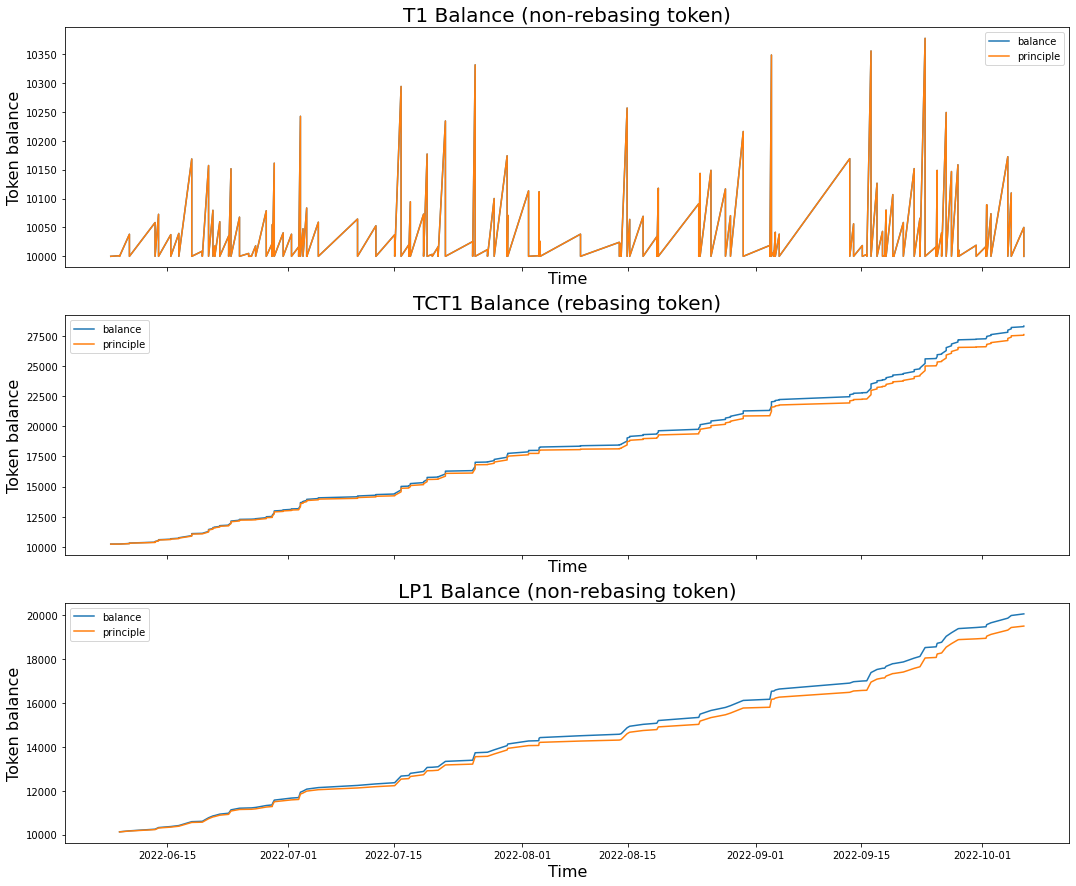

In [9]:
# Analyze Token balances

T1_states = T1.get_state_series(t1_addr)
principle = T1_states.get_principle() 
balance = T1_states.get_balance() 
tSamp = T1_states.get_tstamp()  

fig, (T1_ax, TCT1_ax, LP1_ax) = plt.subplots(nrows=3, sharex=True, sharey=False, figsize=(18, 15))

T1_ax.plot(tSamp[1:], balance[1:], label='balance') 
T1_ax.plot(tSamp[1:], principle[1:], label='principle') 
T1_ax.set_title("T1 Balance (non-rebasing token)", fontsize=20)
T1_ax.set_ylabel("Token balance", fontsize=16)
T1_ax.set_xlabel('Time', fontsize=16)
T1_ax.legend()

TCT1_states = TCT1.get_state_series(tct_addr)
principle = TCT1_states.get_principle() 
balance = TCT1_states.get_balance() 
tSamp = TCT1_states.get_tstamp() 

TCT1_ax.plot(tSamp[1:], balance[1:], label='balance') 
TCT1_ax.plot(tSamp[1:], principle[1:], label='principle') 
TCT1_ax.set_title("TCT1 Balance (rebasing token)", fontsize=20)
TCT1_ax.set_ylabel("Token balance", fontsize=16)
TCT1_ax.set_xlabel('Time', fontsize=16)
TCT1_ax.legend()

LP1_states = LP1.get_state_series(lp1_addr)
principle = LP1_states.get_principle() 
balance = LP1_states.get_balance() 
tSamp = LP1_states.get_tstamp() 

LP1_ax.plot(tSamp[1:], balance[1:], label='balance') 
LP1_ax.plot(tSamp[1:], principle[1:], label='principle') 
LP1_ax.set_title("LP1 Balance (non-rebasing token)", fontsize=20)
LP1_ax.set_ylabel("Token balance", fontsize=16)
LP1_ax.set_xlabel('Time', fontsize=16)
LP1_ax.legend()


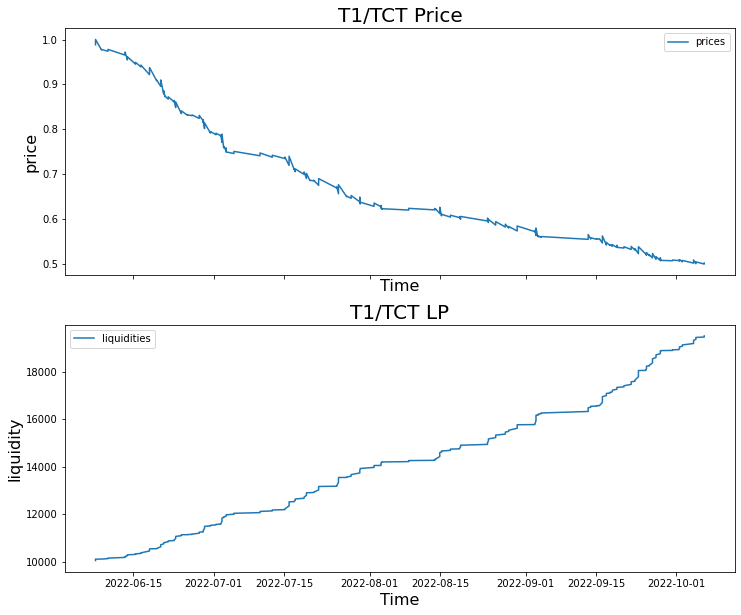

In [10]:
lp = orchestrator.get_liquidity_pool('T1/TCT')
tSamp = lp.get_lp_events().get_dates()
prices = lp.get_lp_events().get_prices()
liquidities = lp.get_lp_events().get_liquidity_values()

fig, (L_ax, P_ax) = plt.subplots(nrows=2, sharex=True, sharey=False, figsize=(12, 10))

L_ax.plot(tSamp[1:], prices[1:], label='prices') 
L_ax.set_title("T1/TCT Price", fontsize=20)
L_ax.set_ylabel("price", fontsize=16)
L_ax.set_xlabel('Time', fontsize=16)
L_ax.legend()

P_ax.plot(tSamp[1:], liquidities[1:], label='liquidities') 
P_ax.set_title("T1/TCT LP", fontsize=20)
P_ax.set_ylabel("liquidity", fontsize=16)
P_ax.set_xlabel('Time', fontsize=16)
P_ax.legend()
